# Plot Spectra of SSH with and without barotropic component

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
import os
#import gcm_filters
import xrft
from dask.diagnostics import ProgressBar
#from rechunker import rechunk
import zarr
from xgcm.grid import Grid
import matplotlib

In [2]:
eta_mean = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_mean.zarr')
steric_mean = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/steric_mean.zarr')

In [3]:
uvel_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel_centered.zarr')
vvel_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel_centered.zarr')

uvel_merged = uvel_merged.isel(time=slice(1,1500)).isel(k=0)

vvel_merged = vvel_merged.isel(time=slice(1,1500)).isel(k=0)

eta_merged = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_long.zarr')
eta_merged = eta_merged.isel(time=slice(1,1500))

steric = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/steric_height.zarr')
steric2 = xr.open_zarr('/swot/SUM02/spencer/steric_inc_mean.zarr')

steric2 = steric2.steric - steric_mean.steric + eta_mean.Eta


eta_smd = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_smoothed.zarr')
eta_smd = eta_smd.isel(time=slice(1,1500))

eta_smrd = eta_merged.Eta-eta_smd.eta


grid = Grid(uvel_merged, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/array/core.py:4048: PerformanceWarning: Increasing number of chunks by factor of 32
  **blockwise_kwargs,


In [4]:
DXC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXC.data', dtype='>f4')
DYC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYC.data', dtype='>f4')
DXC_array = (xr.DataArray(DXC.reshape(2160,2160),dims=['j','i']).assign_coords(i=eta_merged.i,j=uvel_merged.j))
DYC_array = (xr.DataArray(DYC.reshape(2160,2160),dims=['j','i']).assign_coords(i=eta_merged.i,j=uvel_merged.j))

In [5]:
YC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YC.data', dtype='>f4')
f = 2*2*np.pi/24/3600*np.sin(YC.reshape(2160,2160)*np.pi/180)
f_array = (xr.DataArray(f,dims=['j','i']).assign_coords(i=uvel_merged.i,j=uvel_merged.j))

In [9]:
unfiltered_ps = xrft.power_spectrum(eta_merged.Eta.isel(time=slice(1,1450)).drop_vars('time').chunk({'time':-1}),dim=['time'],window='hann',window_correction=True)
steric_ps = xrft.power_spectrum(steric.Eta.isel(time=slice(1,1450)).drop_vars('time').chunk({'time':-1}),dim=['time'],window='hann',window_correction=True)
steric2_ps = xrft.power_spectrum(steric2.isel(time=slice(1,1450)).drop_vars('time').chunk({'time':-1}),dim=['time'],window='hann',window_correction=True)
smrd_ps = xrft.power_spectrum(eta_smrd.isel(time=slice(1,1450)).drop_vars('time').chunk({'time':-1}),dim=['time'],window='hann',window_correction=True)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


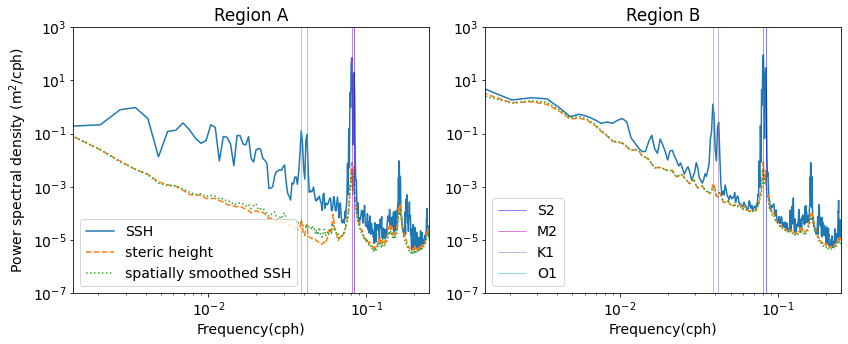

In [10]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

fig=plt.figure(figsize=(12,5))

plt.subplot(121)
unfiltered_ps.isel(i=slice(920,-920),j=slice(920,-920),freq_time=slice(725,2000)).mean(['i','j']).plot(label='SSH')
#steric_ps.isel(i=slice(914,-914),j=slice(905,-905),freq_time=slice(725,2000)).mean(['i','j']).plot(label='steric from T,S')
steric2_ps.isel(i=slice(920,-920),j=slice(920,-920),freq_time=slice(725,2000)).mean(['i','j']).plot(label='steric height',linestyle='--')
smrd_ps.isel(i=slice(920,-920),j=slice(920,-920),freq_time=slice(725,2000)).mean(['i','j']).plot(label='spatially smoothed SSH',linestyle=':')
plt.xscale('log')
plt.yscale('log')
plt.axvline([1/12],label='_nolegend_',color='b',lw=0.5)
plt.axvline([1/12.4206012],label='_nolegend_',color='m',lw=0.5)
plt.axvline([1/23.93447213],label='_nolegend_',color='tab:purple',lw=0.5)
plt.axvline([1/25.81933871],label='_nolegend_',color='c',lw=0.5)
plt.legend(loc='lower left')
plt.xlim(0.0014,0.25)
plt.ylim(10**-7,10**3)
plt.ylabel('Power spectral density (m$^2$/cph)')
plt.xlabel('Frequency(cph)')
plt.title('Region A')

plt.subplot(122)
unfiltered_ps.isel(i=slice(1400,1400+320),j=slice(1160,1160+320),freq_time=slice(725,2000)).mean(['i','j']).plot(label='_nolegend_')
#steric_ps.isel(i=slice(914,-914),j=slice(905,-905),freq_time=slice(725,2000)).mean(['i','j']).plot(label='steric from T,S')
steric2_ps.isel(i=slice(1400,1400+320),j=slice(1160,1160+320),freq_time=slice(725,2000)).mean(['i','j']).plot(label='_nolegend_',linestyle='--')
smrd_ps.isel(i=slice(1400,1400+320),j=slice(1160,1160+320),freq_time=slice(725,2000)).mean(['i','j']).plot(label='_nolegend_',linestyle=':')
plt.xscale('log')
plt.yscale('log')
plt.axvline([1/12],label='S2',color='b',lw=0.5)
plt.axvline([1/12.4206012],label='M2',color='m',lw=0.5)
plt.axvline([1/23.93447213],label='K1',color='tab:purple',lw=0.5)
plt.axvline([1/25.81933871],label='O1',color='c',lw=0.5)
plt.legend(loc='lower left')
plt.xlim(0.0014,0.25)
plt.ylim(10**-7,10**3)
#plt.ylabel('Power spectral density (m$^2$/cph)')
plt.xlabel('Frequency(cph)')
plt.title('Region B')

plt.tight_layout()

fig=plt.gcf()
fig.savefig('steric_spectrum.png')